In [1]:
# This code is written to support the experiments in the book titled:
# "Adaptive Machine Learning Algorithms"
# by
# Chanchal Chatterjee and Vwani P. Roychowdhury
# August 2021
#
# Experiments for Chapter 8 (NOAA.csv Data)
# Anomaly detection
# EVD on semi-stationary and non-stationary data
# Median based detection
#
# Author: Chanchal Chatterjee
#

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")


In [3]:
# Data obtained from USP DS Repository https://sites.google.com/view/uspdsrepository
# Load the data in your unique bucket.
# Here AdaptiveMLAlgorithms/Data/NOAA.csv

In [4]:
# get data here: https://sites.google.com/view/uspdsrepository
dataset   = pd.read_csv("../Data/NOAA.csv")
dataset = dataset.dropna()
print(dataset.shape)
print(dataset.head())


(18159, 9)
     F1    F2      F3   F4    F5    F6    F7    F8  Class
0  19.8  14.0  1019.6  8.4   9.9  15.9  28.9  14.0      1
1  26.8  22.2  1006.2  8.1  10.9  19.0  34.0  21.0      1
2  34.6  32.9  1004.6  3.9  13.8  22.0  36.0  33.1      2
3  26.4  21.5  1006.9  8.0  18.7  30.1  39.9  16.0      2
4  14.7   7.9  1009.9  8.1  14.1  22.0  21.0   9.0      1


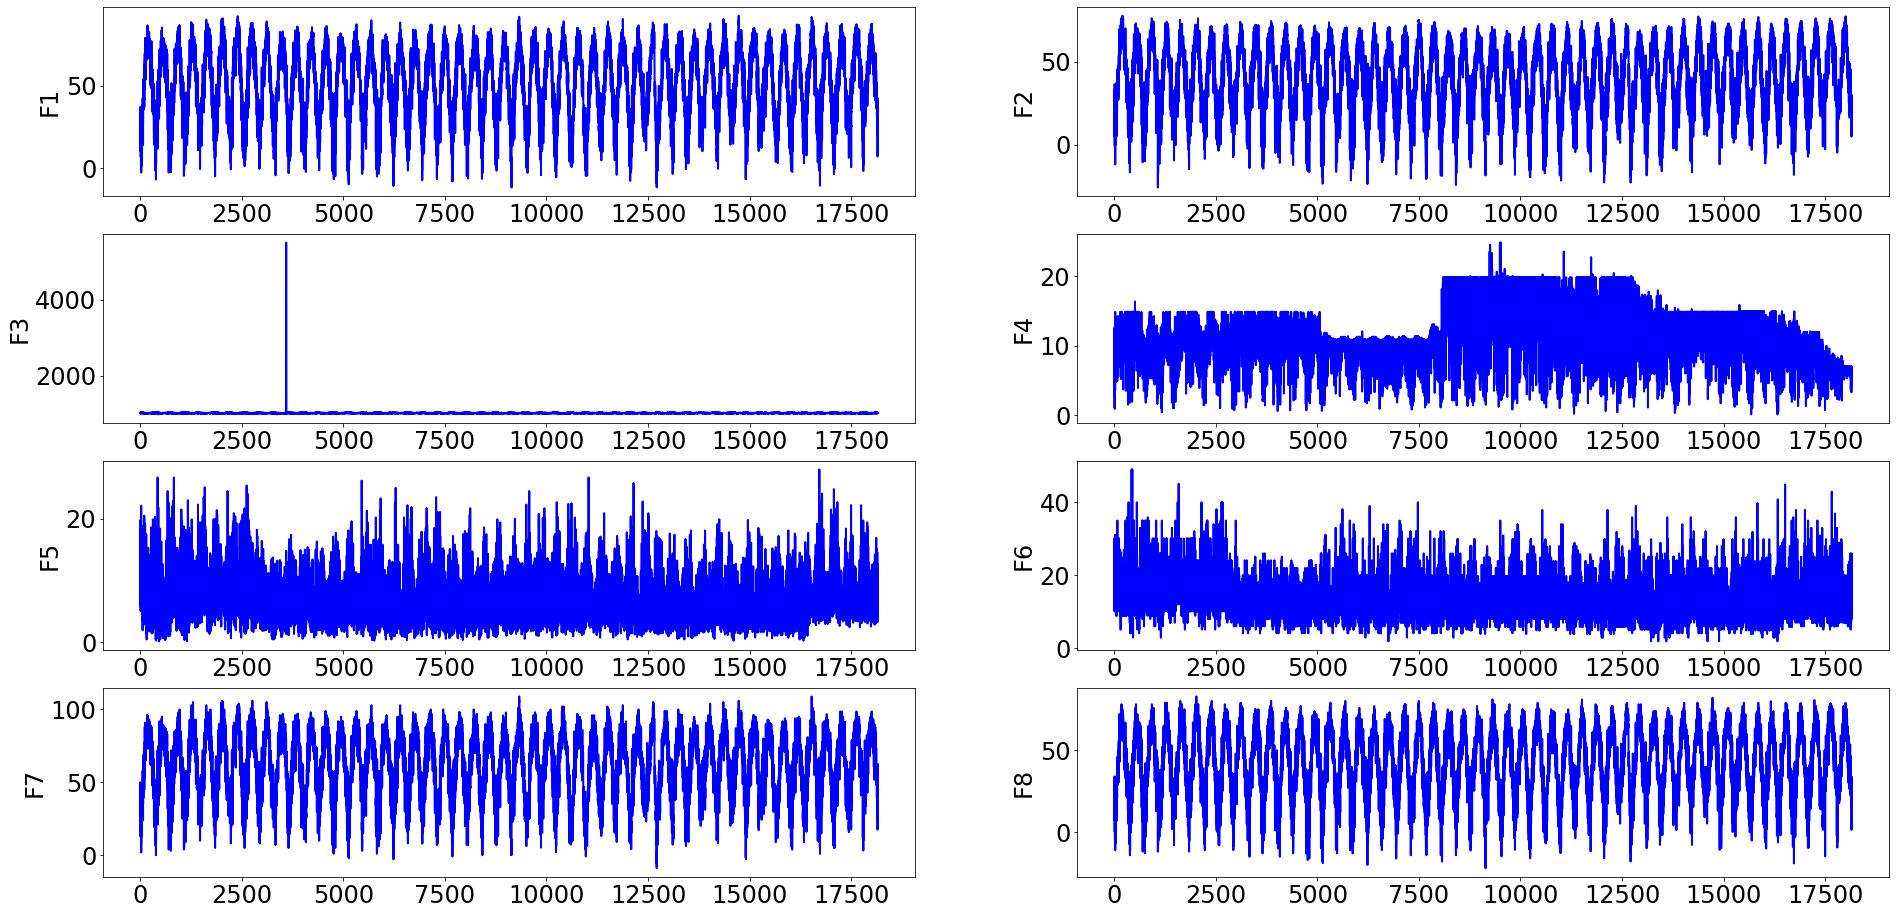

In [5]:
plt.figure(figsize=(32, 16))
plt.rcParams.update({'font.size': 24})
cols = dataset.columns
for i in range(2*(dataset.shape[1]//2)):
    plt.subplot(4, 2, i+1)
    plt.ylabel(cols[i])
    plt.plot(dataset[cols[i]], lw=2, color='b')
plt.show()


------------------------------------------
## Adaptive Linear Eigen Decomposition
### Using Semi-Stationary Components Only


In [6]:
dataset2 = dataset.drop(['F3', 'F4', 'Class'],1)
print(dataset2.shape)
print(dataset2.head())


(18159, 6)
     F1    F2    F5    F6    F7    F8
0  19.8  14.0   9.9  15.9  28.9  14.0
1  26.8  22.2  10.9  19.0  34.0  21.0
2  34.6  32.9  13.8  22.0  36.0  33.1
3  26.4  21.5  18.7  30.1  39.9  16.0
4  14.7   7.9  14.1  22.0  21.0   9.0


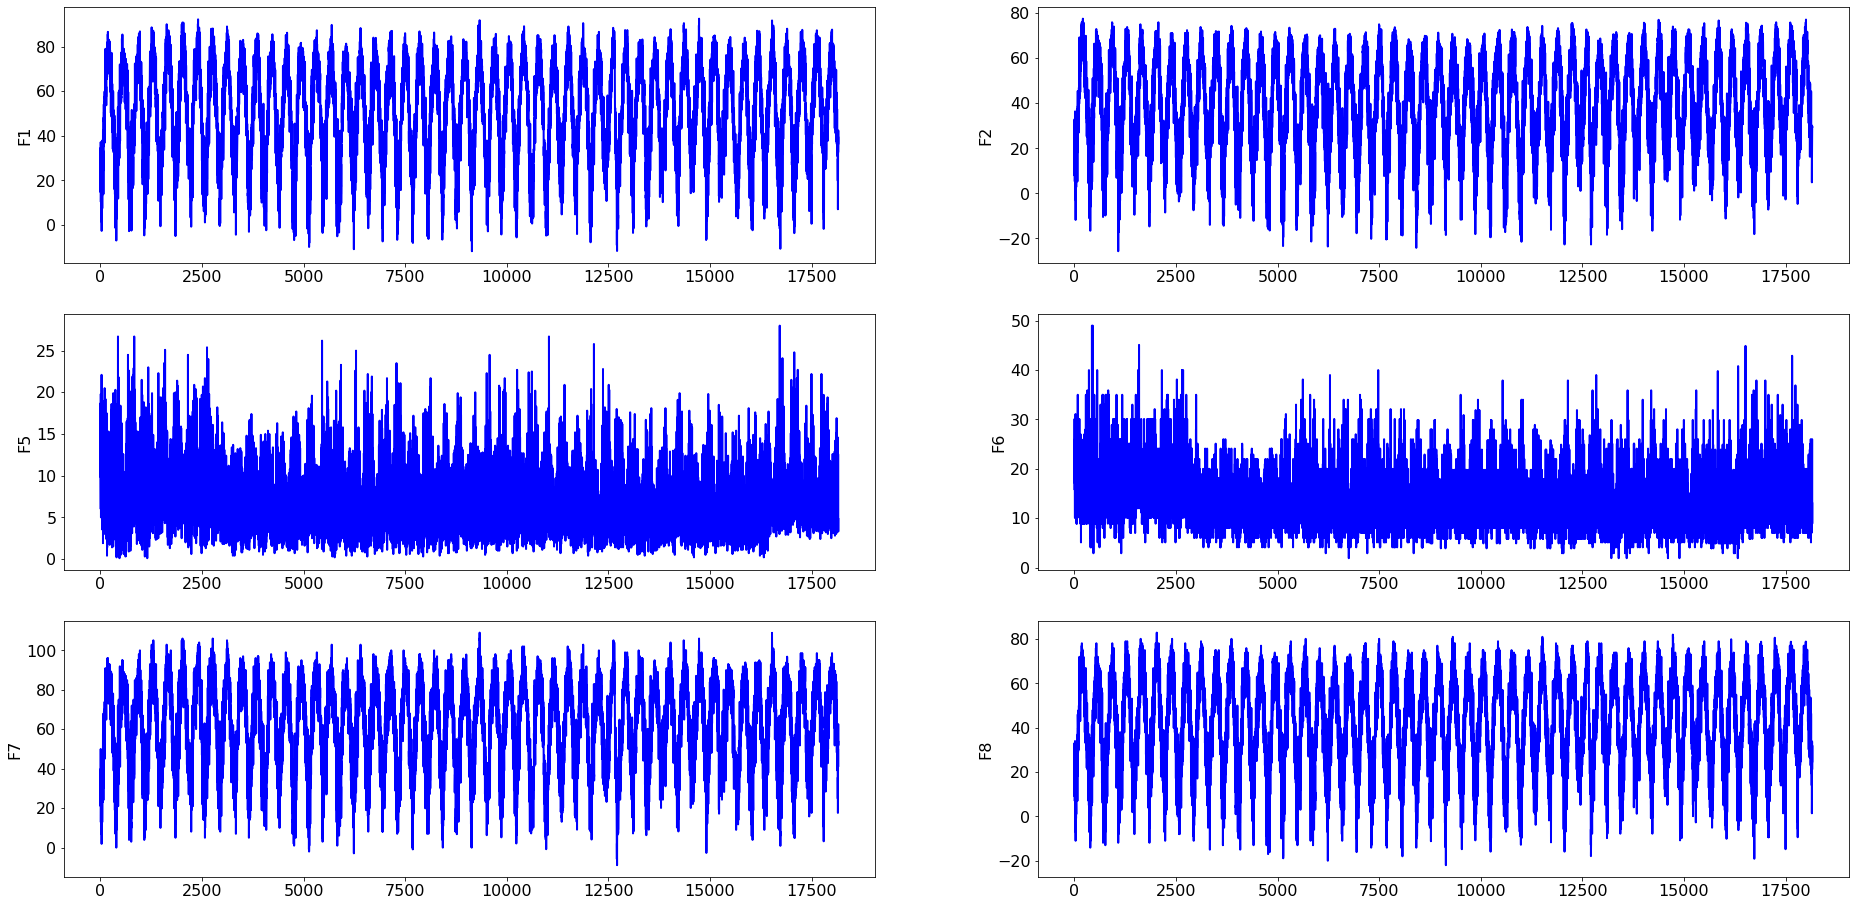

In [7]:
plt.figure(figsize=(32, 16))
plt.rcParams.update({'font.size': 16})
cols = dataset2.columns
for i in range(dataset2.shape[1]):
    plt.subplot(3, 2, i+1)
    plt.ylabel(cols[i])
    plt.plot(dataset2[cols[i]], lw=2, color='b')
plt.show()


In [8]:
# Adaptive algorithm
from numpy import linalg as la

nSamples = dataset2.shape[0]
nDim = dataset2.shape[1]

A = np.zeros(shape=(nDim,nDim)) # stores adaptive correlation matrix
N = np.zeros(shape=(1,nDim)) # stores eigen norms
W = 0.1 * np.ones(shape=(nDim,nDim)) # stores adaptive eigenvectors
for iter in range(nSamples):
    cnt = iter + 1
    x = np.array(dataset2.iloc[iter])
    x = x.reshape(nDim,1)
    A = A + (1.0/cnt)*((np.dot(x, x.T)) - A)
    etat = 1.0/(20000 + cnt)
    # Deflated Gradient Descent
    W = W + etat*(A @ W - 0.5*W @ np.triu(W.T @ A @ W) - 0.5*A @ W @ np.triu(W.T @ W))
    newnorm = la.norm(W, axis=0)
    N = np.vstack([N, newnorm])
print("W=\n", W)

W=
 [[ 0.50990947 -0.03905001  0.06776102 -0.15190908 -0.08323616 -0.00944069]
 [ 0.40807084 -0.42802758 -0.39013373  0.34898018  0.23226237  0.04045756]
 [ 0.05872976  0.36032382 -0.38912162 -0.02539733  0.02482943  0.02352324]
 [ 0.11878811  0.66394776 -0.51638577  0.09451187  0.08839054  0.02693955]
 [ 0.6065603   0.3811755   0.57026289  0.07158937 -0.04039496 -0.03680527]
 [ 0.43358428 -0.31513917 -0.31609827 -0.27238761 -0.0917638   0.01394584]]


In [9]:
import math
from scipy.linalg import eigh
WTW = W.T @ W
WTAW = W.T @ A @ W
#print("WTW=\n", WTW)
#print("WTAW=\n", WTAW)
eigvals, eigvecs = eigh(A)
#print("PHI=\n", eigvecs)
print("Lambda=\n", eigvals)
print("Diags of WTAW")
print([WTAW[i,i] for i in range(len(WTAW[0]))])
print("Diags of WTW")
print([WTW[i,i] for i in range(len(WTW[0]))])


Lambda=
 [1.50074973e+00 2.89948694e+00 1.08152503e+01 3.91302561e+01
 1.09145583e+02 1.17167245e+04]
Diags of WTAW
[11716.724478393959, 109.14497008817243, 39.129337113150115, 2.6914655331375616, 1.4914767702289944, 0.17644756842942588]
Diags of WTW
[1.0000000000214864, 0.9999998587425208, 0.9999836613408322, 0.23376109852437885, 0.07935580456361561, 0.004554137236898654]


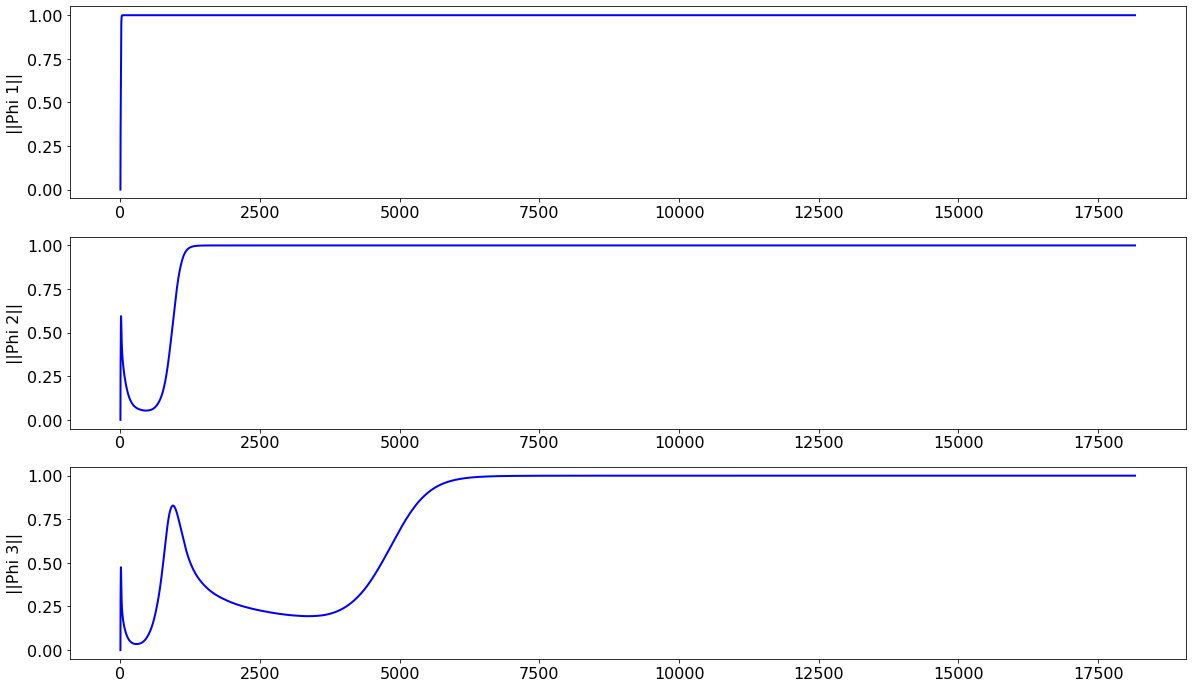

In [10]:
cols = dataset2.columns
norms = pd.DataFrame({cols[0]: N[:, 0], cols[1]: N[:, 1], cols[2]: N[:, 2], cols[3]: N[:, 3]})

plt.figure(figsize=(20, 12))
plt.rcParams.update({'font.size': 16})
cols = norms.columns
for i in range(3):
    plt.subplot(3, 1, i+1)
    plt.ylabel('||Phi {}||'.format(i+1))
    plt.plot(norms[cols[i]], lw=2, color='b')
plt.show()


------------------------------------------
## Adaptive Linear Eigen Decomposition
### Using all Non Stationary Components


In [11]:
dataset1 = dataset.drop(['Class'], 1)

print(dataset1.shape)
print(dataset1.head())


(18159, 8)
     F1    F2      F3   F4    F5    F6    F7    F8
0  19.8  14.0  1019.6  8.4   9.9  15.9  28.9  14.0
1  26.8  22.2  1006.2  8.1  10.9  19.0  34.0  21.0
2  34.6  32.9  1004.6  3.9  13.8  22.0  36.0  33.1
3  26.4  21.5  1006.9  8.0  18.7  30.1  39.9  16.0
4  14.7   7.9  1009.9  8.1  14.1  22.0  21.0   9.0


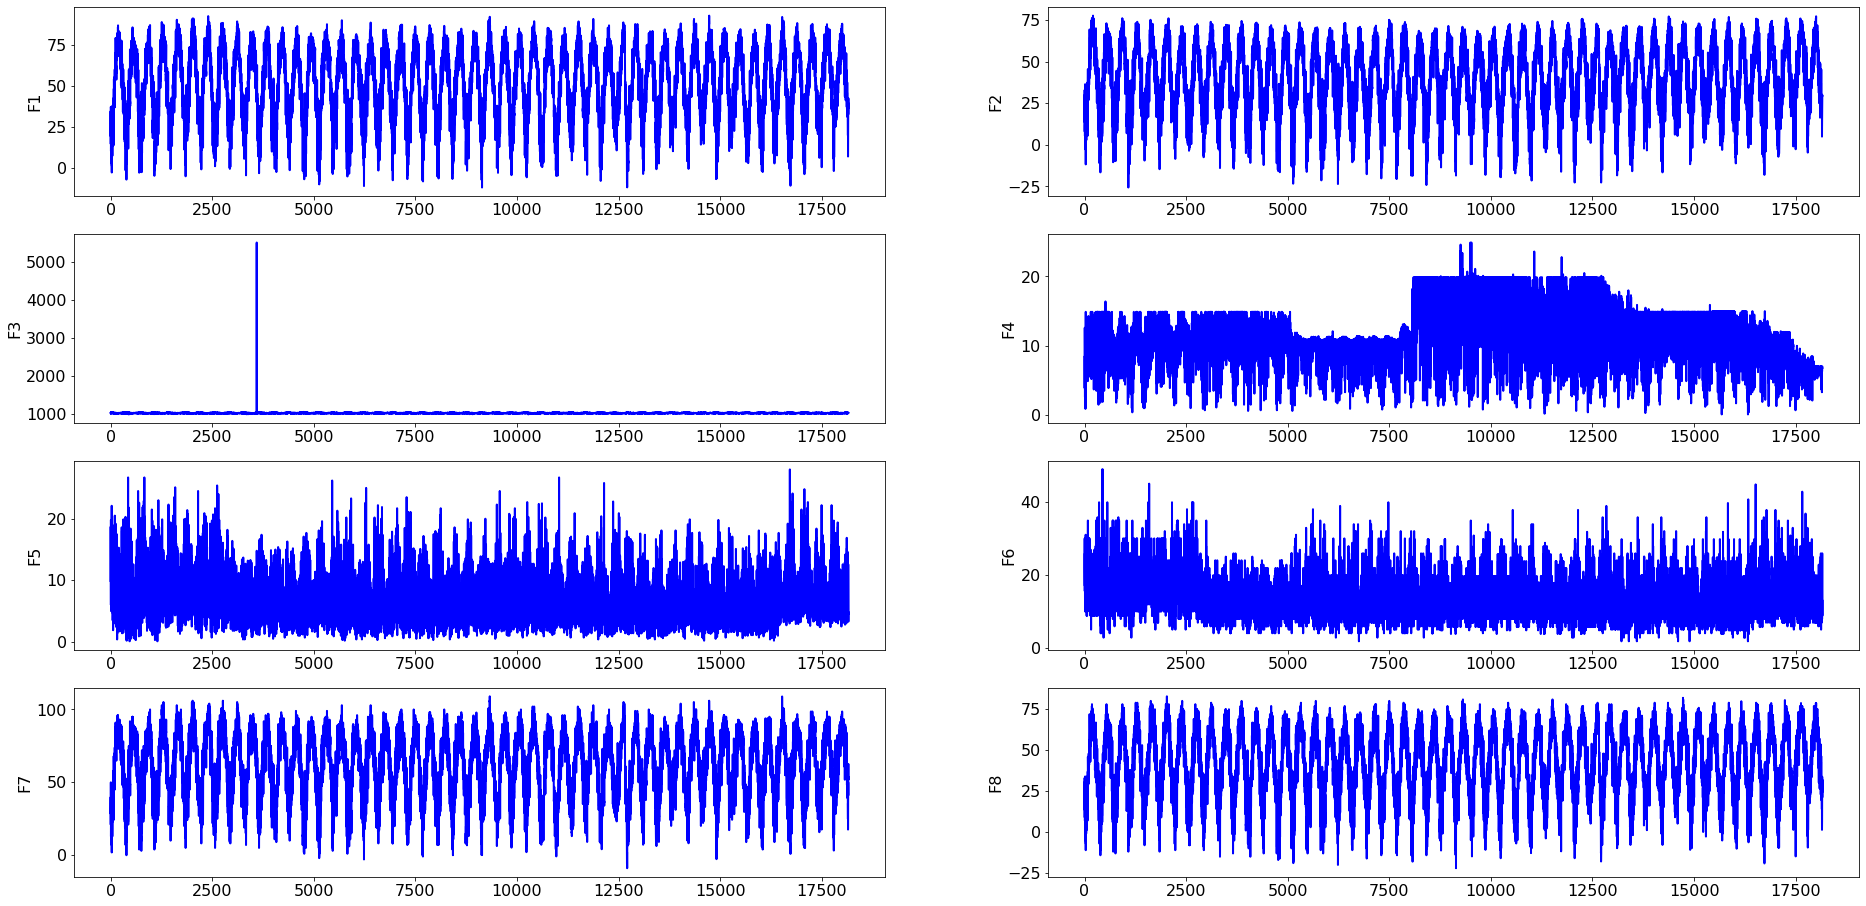

In [12]:
plt.figure(figsize=(32, 16))
plt.rcParams.update({'font.size': 16})
cols = dataset1.columns
for i in range(dataset1.shape[1]):
    plt.subplot(4, 2, i+1)
    plt.ylabel(cols[i])
    plt.plot(dataset1[cols[i]], lw=2, color='b')
plt.show()


In [13]:
# Adaptive algorithm
from numpy import linalg as la

nSamples = dataset1.shape[0]
nDim = dataset1.shape[1]

A = np.zeros(shape=(nDim,nDim)) # stores adaptive correlation matrix
N = np.zeros(shape=(1,nDim)) # stores eigen norms
W = 0.1 * np.ones(shape=(nDim,nDim)) # stores adaptive eigenvectors
for iter in range(nSamples//1):
    cnt = iter + 1
    x = np.array(dataset1.iloc[iter])
    x = x.reshape(nDim,1)
    A = A + (1.0/cnt)*((np.dot(x, x.T)) - A)
    etat = 1.0/(1500000 + cnt)
    # Deflated Gradient Descent
    W = W + etat*(A @ W - 0.5*W @ np.triu(W.T @ A @ W) - 0.5*A @ W @ np.triu(W.T @ W))
    newnorm = la.norm(W, axis=0)
    N = np.vstack([N, newnorm])
print("W=\n", W)

W=
 [[ 4.98220761e-02  5.07639874e-01  8.93325857e-02  3.38302222e-02
   1.77613740e-02  1.08760819e-02  7.26462352e-03  5.12230012e-03]
 [ 3.88052911e-02  4.72605746e-01  8.32789521e-02  3.33204557e-02
   1.93311579e-02  1.33116155e-02  9.99490016e-03  7.85197904e-03]
 [ 9.95116131e-01 -9.59553727e-02 -1.68983474e-02 -6.52065206e-03
  -3.60571432e-03 -2.40793994e-03 -1.81077563e-03 -1.47766010e-03]
 [ 1.13860384e-02  1.70536873e-02  4.34415873e-03  4.20964105e-03
   5.51917348e-03  7.06877329e-03  8.63174189e-03  1.01527676e-02]
 [ 6.84647804e-03 -9.08303721e-03 -9.28758098e-04  2.35256775e-03
   5.36687413e-03  8.14156989e-03  1.07023541e-02  1.30904454e-02]
 [ 1.36871334e-02 -8.32884623e-03 -8.58397435e-04  2.43181491e-03
   5.90584560e-03  9.19340843e-03  1.22265091e-02  1.50363402e-02]
 [ 6.05882969e-02  5.23104047e-01  9.14870105e-02  3.34433067e-02
   1.66661867e-02  9.56167994e-03  5.89222000e-03  3.75582388e-03]
 [ 4.14849346e-02  4.85445725e-01  8.57656450e-02  3.34082159e-02

In [14]:
import math
from scipy.linalg import eigh
WTW = W.T @ W
WTAW = W.T @ A @ W
#print("WTW=\n", WTW)
#print("WTAW=\n", WTAW)
eigvals, eigvecs = eigh(A)
#print("PHI=\n", eigvecs)
print("Lambda=\n", eigvals)
print("Diags of WTAW")
print([WTAW[i,i] for i in range(len(WTAW[0]))])
print("Diags of WTW")
print([WTW[i,i] for i in range(len(WTW[0]))])


Lambda=
 [1.49257112e+00 2.84211008e+00 7.88543533e+00 1.37357363e+01
 3.91646467e+01 4.52577018e+01 1.74315474e+03 1.04625874e+06]
Diags of WTAW
[1046258.7412009906, 1743.1450029343068, 53.938359206605185, 7.890913077110417, 2.2748453012699708, 0.9094217324750743, 0.44054560263929493, 0.24410569341481944]
Diags of WTW
[1.0000000000014757, 0.9999999619246012, 0.030947338976720737, 0.004560988634876559, 0.0014108753032824408, 0.000735016469621145, 0.0006013788785250283, 0.0006465017750780021]


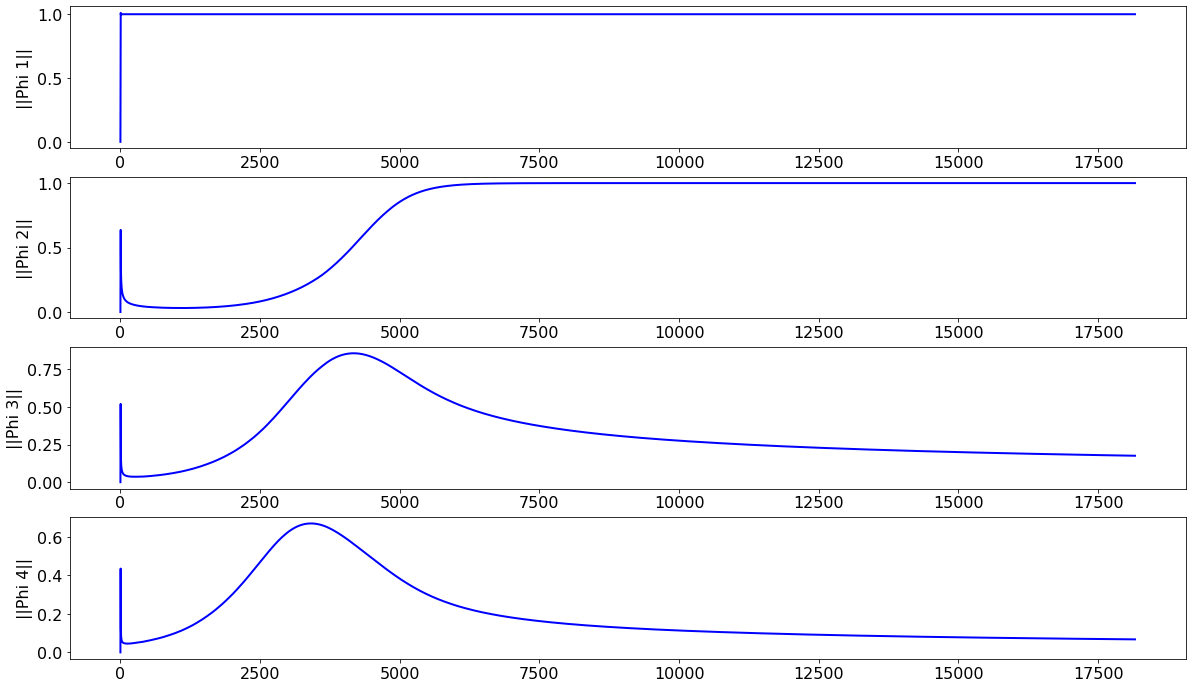

In [15]:
cols = dataset.columns
norms = pd.DataFrame({cols[0]: N[:, 0], cols[1]: N[:, 1], cols[2]: N[:, 2], cols[3]: N[:, 3], \
                      cols[4]: N[:, 4], cols[5]: N[:, 5], cols[6]: N[:, 6]})

plt.figure(figsize=(20, 12))
plt.rcParams.update({'font.size': 16})
cols = norms.columns
for i in range(4):
    plt.subplot(4, 1, i+1)
    plt.ylabel('||Phi {}||'.format(i+1))
    plt.plot(norms[cols[i]], lw=2, color='b')
plt.show()

------------------------------------------
## Anomaly Detection with adaptive median


In [16]:
dataset1 = dataset.drop(['Class'], 1)
dataset1 = 100*(dataset1 - dataset1.min())/(dataset1.max() - dataset1.min())

print(dataset1.shape)
print(dataset1.head())


(18159, 8)
          F1         F2        F3         F4         F5         F6         F7  \
0  30.230326  38.431752  0.870988  33.467742  35.125448  29.723992  32.061069   
1  36.948177  46.369797  0.574763  32.258065  38.709677  36.305732  36.386768   
2  44.433781  56.727977  0.539393  15.322581  49.103943  42.675159  38.083121   
3  36.564299  45.692159  0.590238  31.854839  66.666667  59.872611  41.391009   
4  25.335893  32.526621  0.656557  32.258065  50.179211  42.675159  25.360475   

          F8  
0  34.318398  
1  40.991420  
2  52.526215  
3  36.224976  
4  29.551954  


In [17]:
# Adaptive algorithm
from numpy import linalg as la

nSamples = dataset1.shape[0]
nDim = dataset1.shape[1]

w = np.zeros(shape=(nDim,1)) # stores adaptive eigenvectors
anam = np.zeros(shape=(nDim,nSamples))
mdks = np.zeros(shape=(nDim,nSamples))
for iter in range(nSamples):
    cnt = iter + 1
    x = np.array(dataset1.iloc[iter])
    x = x.reshape(nDim,1)
    #Eq.2.20
    w = w + (10.0/(1 + iter)) * np.sign(x - w)
    mdks[:,iter] = w.T
    y = (np.abs(x-w) > 4*w)*1
    anam[:,iter] = y.T
print("w=\n", w.T)


w=
 [[55.16689202 59.15711444  0.79675749 45.67312893 24.31479977 25.34451061
  56.74435027 56.95489558]]


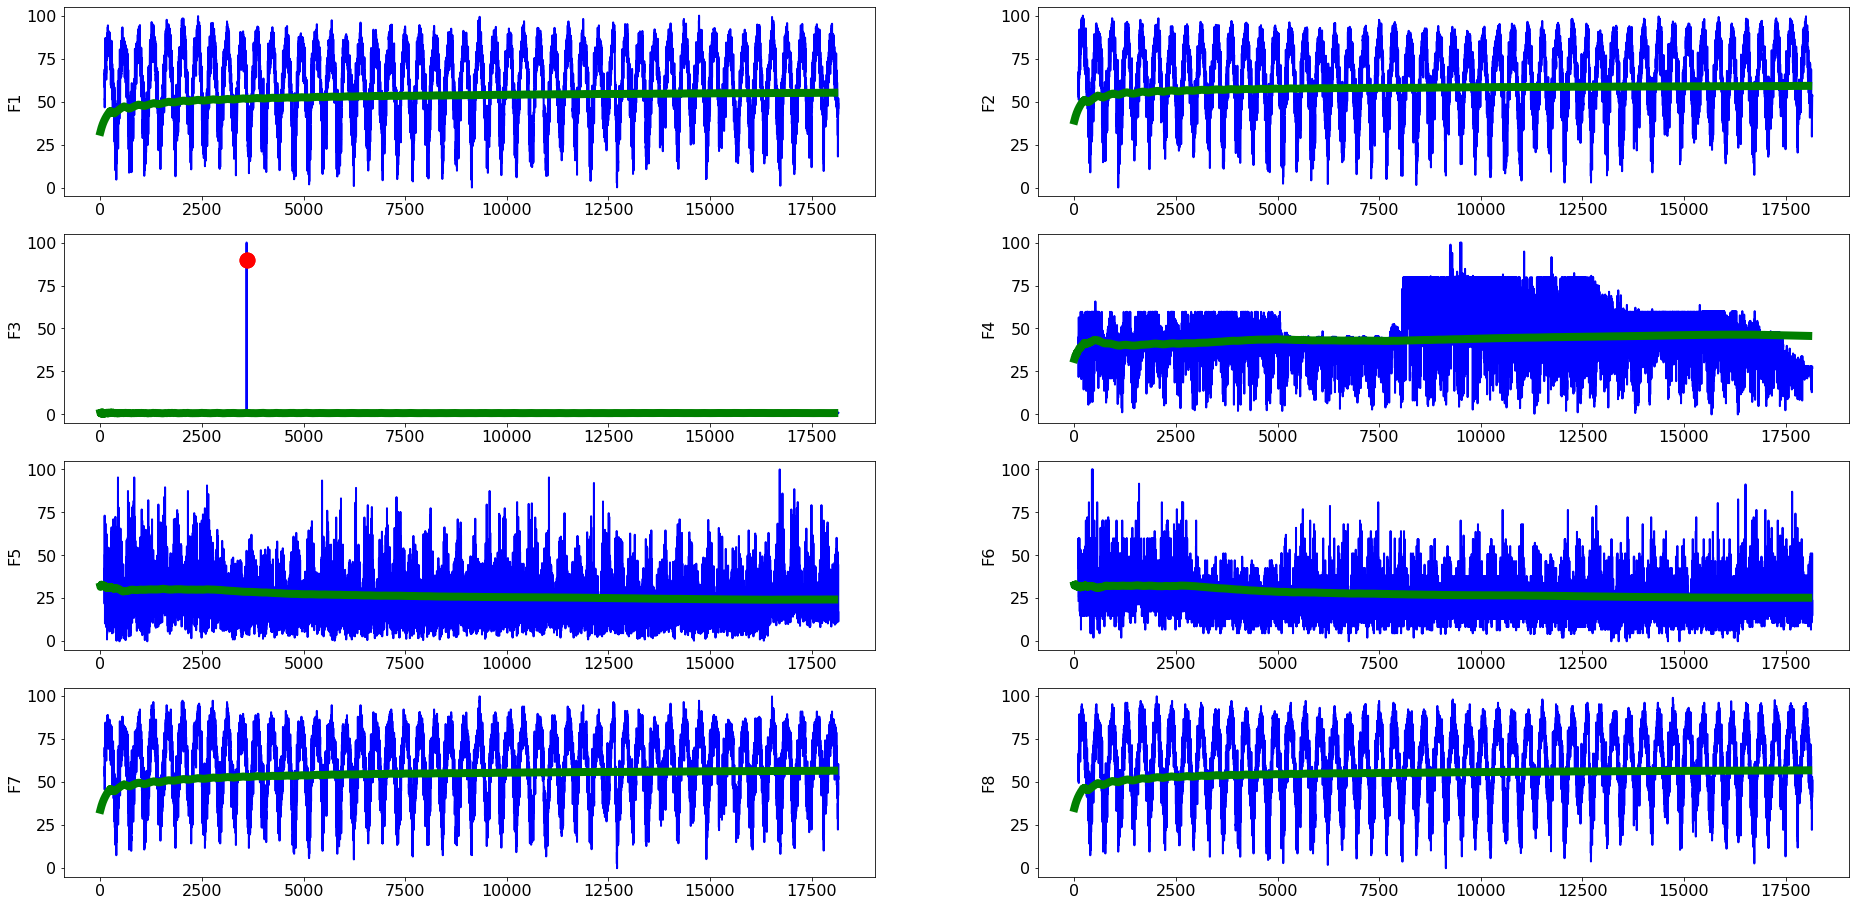

In [18]:
df = dataset1
plt.figure(figsize=(32, 16))
plt.rcParams.update({'font.size': 16})
cols = df.columns
for i in range(df.shape[1]):
    plt.subplot(4, 2, i+1)
    plt.ylabel(cols[i])
    plt.plot(df[cols[i]][100:], lw=2, color='b')
    plt.plot(mdks[i][100:], lw=8, color='g')
    for j in range(100,anam.shape[1]):
        if (anam[i,j] > 0):
            plt.plot(j, 90*anam[i,j], 'o', markersize=15, color='r')
plt.show()
